In [2]:
import sympy as sp
import jax.numpy as jnp
from sympy.utilities.lambdify import lambdify
import jax
import numpy as np
import equinox as eqx
import matplotlib.pyplot as plt

In [3]:
x,y=sp.symbols('x y')
equation="sin(x)+cos(y)"
equation=sp.sympify(equation)

f=lambdify((x,y), equation,"jax")
directly_jitted_jax=jax.jit(f)

eval_dict={'x':1,'y':3}
jax_equation = lambda x, y: jnp.array(f(x, y))

jitted_jax_equation=jax.jit(jax_equation)
directly_jitted_jax(**eval_dict)
jitted_jax_equation(1,3)

Array(-0.14852154, dtype=float32, weak_type=True)

In [4]:
%timeit f(1,3).block_until_ready()
%timeit jax_equation(1,3).block_until_ready()
%timeit jitted_jax_equation(1,3).block_until_ready()
%timeit directly_jitted_jax(**eval_dict).block_until_ready()
%timeit np.math.cos(1)+np.cos(3)


12.2 µs ± 274 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
49.9 µs ± 1.02 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
4.69 µs ± 107 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
5.03 µs ± 165 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


<magic-timeit>:1: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`


2.68 µs ± 120 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


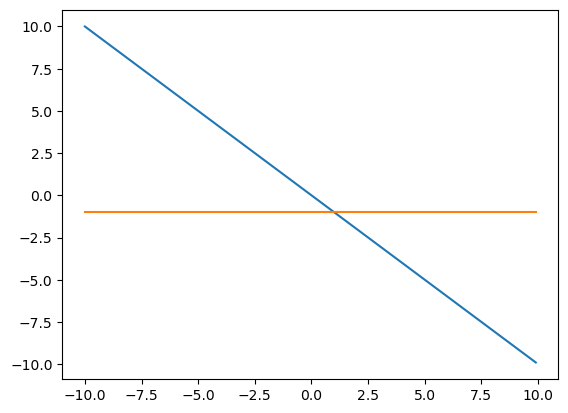

In [5]:
x,y=sp.symbols('x y')
equation2="-x"
equation2=sp.sympify(equation2)

f2=lambdify((x), equation2,"jax")
f2_jitted=jax.jit(f2)
f2_vmap=jax.vmap(f2_jitted)


d=jax.grad(f2_jitted,argnums=0,allow_int=True)

d=jax.vmap(d)
d=jax.jit(d)

x1=jnp.arange(-10,10,0.1)

sol=f2_vmap(x1)
sol_diff=d(x1)

plt.plot(x1,sol)
plt.plot(x1,sol_diff)






In [6]:
import time

In [7]:
eval_dict={'x':2}
f2_jitted(**eval_dict)

Array(-2, dtype=int32, weak_type=True)

Results:
t=0.0, y=[2.0]
t=0.001, y=[1.9980009996600283]
t=0.002, y=[1.9960039973134265]
t=0.003, y=[1.9940089909701648]
t=0.004, y=[1.9920159786402132]
t=0.005, y=[1.9900249583335414]
t=0.006, y=[1.98803592806012]
t=0.007, y=[1.9860488858299188]
t=0.008, y=[1.9840638296529078]
t=0.009000000000000001, y=[1.9820807575390573]
t=0.01, y=[1.980099667498337]
t=0.011, y=[1.9781205567740816]
t=0.012, y=[1.976143422680305]
t=0.013000000000000001, y=[1.9741682633329962]
t=0.014, y=[1.9721950768481453]
t=0.015, y=[1.9702238613417413]
t=0.016, y=[1.9682546149297737]
t=0.017, y=[1.966287335728232]
t=0.018000000000000002, y=[1.9643220218531054]
t=0.019, y=[1.9623586714203836]
t=0.02, y=[1.960397282546056]
t=0.021, y=[1.958437853346112]
t=0.022, y=[1.9564803819365408]
t=0.023, y=[1.9545248664333321]
t=0.024, y=[1.9525713049524753]
t=0.025, y=[1.95061969560996]
t=0.026000000000000002, y=[1.948670036521775]
t=0.027, y=[1.9467223258039104]
t=0.028, y=[1.9447765615723551]
t=0.029, y=[1.9428327419430989]


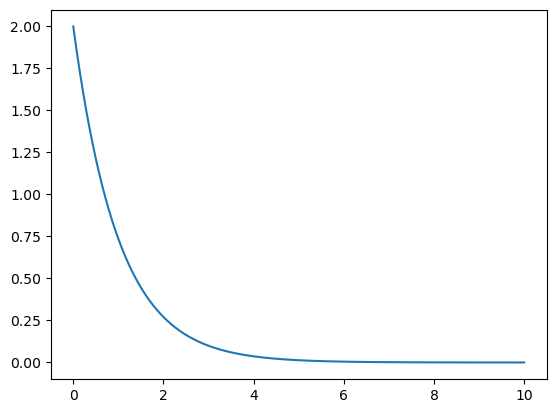

In [8]:
import diffrax
from diffrax import diffeqsolve, ODETerm, Dopri5,SaveAt


jax.config.update("jax_enable_x64", True)


flux=f2_jitted
parameter_indice_dict={'x':10}
def f(t,y,args=(flux,parameter_indice_dict)):
    dy=0
    dy=flux(y[parameter_indice_dict['x']])
    
    return dy


term=ODETerm(f)
solver = diffrax.Kvaerno5()
y0 = jnp.array([2.])
save_at=SaveAt(ts=jnp.arange(0,10,0.001))
stepsize_controller = diffrax.PIDController(rtol=1e-8, atol=1e-8)

start=time.time()
sol = diffeqsolve(term, solver, t0=0, t1=100,saveat=save_at, dt0=0.01, y0=y0,args=[flux,parameter_indice_dict],stepsize_controller=stepsize_controller)
end = time.time()

print("Results:")
for ti, yi in zip(sol.ts, sol.ys):
    print(f"t={ti.item()}, y={yi.tolist()}")
print(f"Took {sol.stats['num_steps']} steps in {end - start} seconds.")

plt.plot(sol.ts,sol.ys)


(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
(2,)
0.4457509517669678


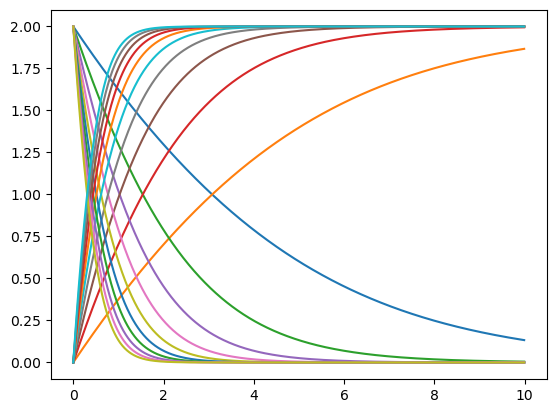

In [40]:
##Michaelis_Menten
y0=jnp.array([1,0])
S,Ks,Vmax=sp.symbols('S Ks Vmax')


MM="(Vmax*S)/(S+Ks)"
MM=sp.sympify(MM,locals={"S":S,"Ks":Ks,"Vmax":Vmax})

f2=sp.lambdify((S,Ks,Vmax), MM,"jax")
f2_jitted=jax.jit(f2)



class torch_kinetic_model():
    def __init__(self,f2_jitted,pars):
        #add a dictionary of what to evaluate self.fun on given y
        self.func=f2_jitted
        self.pars=pars

    def __call__(self,t,y,*args):
        dY0=- self.func(y[0],**self.pars)
        dY1= + self.func(y[0],**self.pars)
        dY=jnp.stack([dY0,dY1])
        print(dY.shape)
        return dY



met={'S':1.0,'x':2}
pars={'Vmax':1,'Ks':3}
start=time.time()

for i in range(10):
    # pars['Vmax']=i+1
    MM_model=torch_kinetic_model(f2_jitted,pars=pars)
    term=ODETerm(MM_model)
    term.vector_field.pars['Vmax']=i+1
    solver = diffrax.Dopri5()
    y0 = jnp.array([2.,0])
    save_at=SaveAt(ts=jnp.arange(0,10,0.01))
    stepsize_controller = diffrax.PIDController(rtol=1e-3, atol=1e-6)



    # for i in range(100):
    sol = diffeqsolve(term, solver, t0=0, t1=10,saveat=save_at,dt0=0.001,  y0=y0,stepsize_controller=stepsize_controller)
        # sol = diffeqsolve(term, solver, t0=0, t1=10,saveat=save_at, dt0=0.01, y0=y0)
    plt.plot(sol.ts,sol.ys)
end = time.time()



print((end-start)/10)

plt.show()



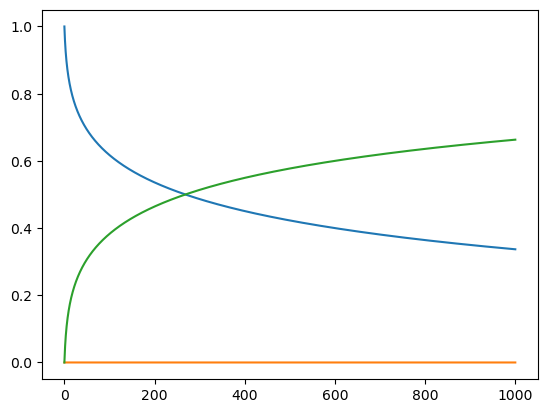

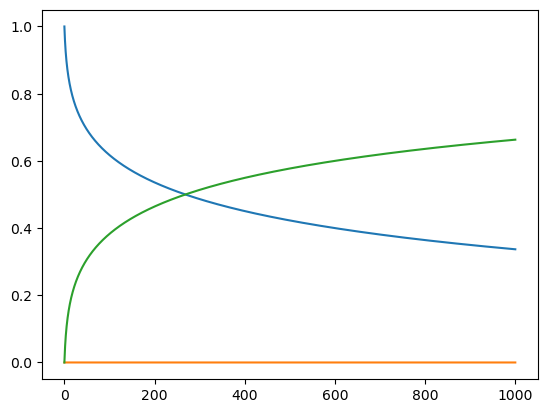

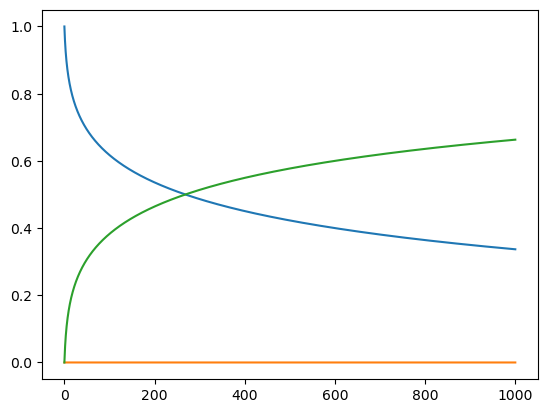

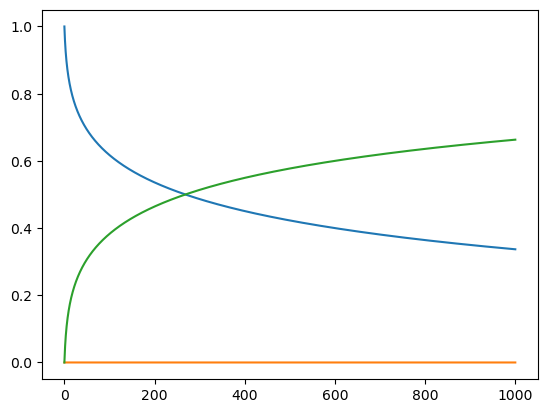

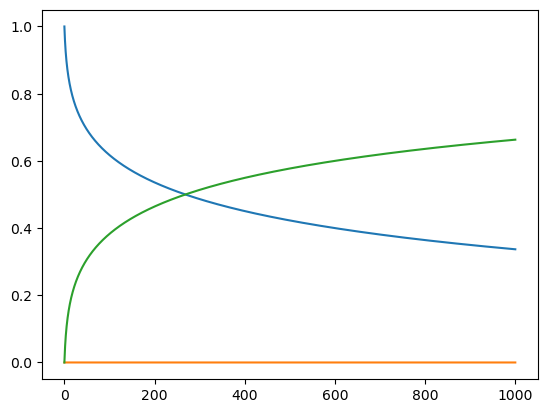

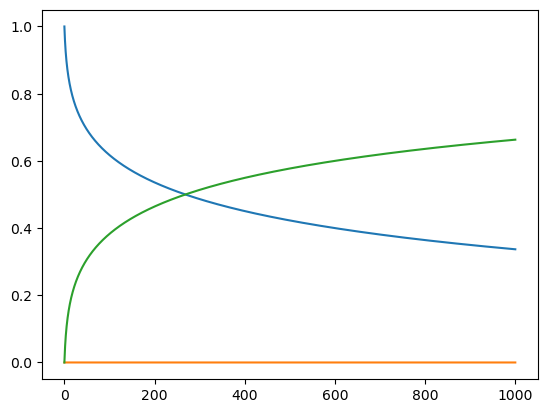

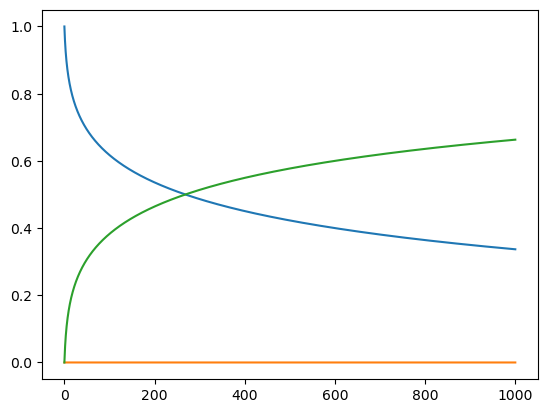

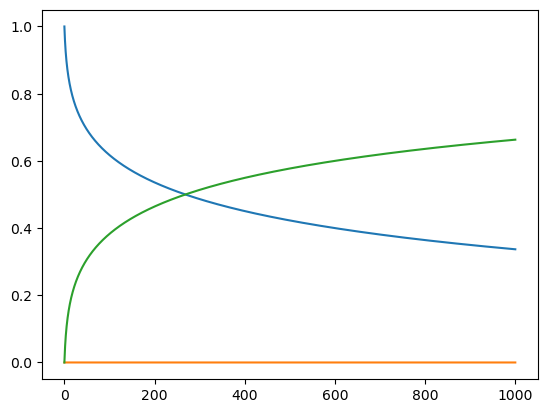

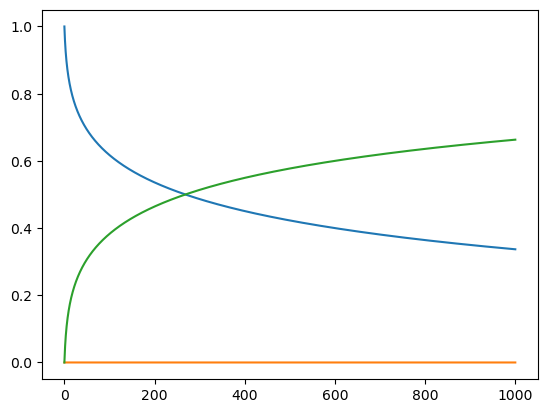

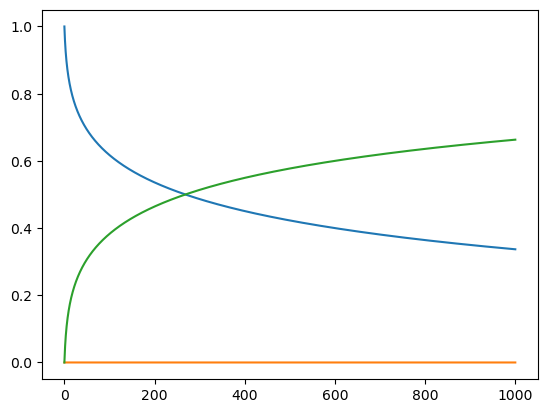

0.23121278285980223


In [14]:
jax.config.update("jax_enable_x64", True)

f0_str = "-k1 * y0 + k3 * y1 * y2"
f1_str = "k1 * y0 - k2 * y1**2 - k3 * y1 * y2"
f2_str = "k2 * y1**2"


f0=sp.sympify(f0_str)
f1=sp.sympify(f1_str)
f2=sp.sympify(f2_str)
y0 ,y1 ,y2, k1, k2, k3=sp.symbols('y0 y1 y2 k1 k2 k3')

expected_vars=[y0 ,y1 ,y2, k1, k2, k3]
f0=sp.lambdify(expected_vars, f0,"jax")
f1=sp.lambdify(expected_vars, f1,"jax")
f2=sp.lambdify(expected_vars,f2,"jax")

f0_jit=jax.jit(f0)
f1_jit=jax.jit(f1)
f2_jit=jax.jit(f2)
f_jitted_list=[f0_jit,f1_jit,f2_jit]


class torch_kinetic_model():
    def __init__(self,f_jitted,pars):
        #add a dictionary of what to evaluate self.fun on given y
        self.func=f_jitted
        self.pars=pars

    def __call__(self,t,y,*args):

        met1=dict(zip(['y0','y1','y2'],y[jnp.array([0,1,2])]))
    
        dy0=self.func[0](**met1,**self.pars)

        dy1=self.func[1](**met1,**self.pars)
        dy2=self.func[2](**met1,**self.pars)

        return jnp.stack([dy0,dy1,dy2])


pars={'k1':0.04,'k2':3e7,'k3':1e4}
Roberts_Problem=torch_kinetic_model(f_jitted_list,pars=pars)
Roberts_Problem=jax.jit(Roberts_Problem)
term=ODETerm(Roberts_Problem)
start=time.time()

for i in range(10):


    # Roberts_Problem.pars=pars




    # term.vector_field.pars['k3']=pars['k3']*(i+1*10)
    # print(term.vector_field.pars)
    solver = diffrax.Kvaerno5()
    y0 = jnp.array([1.0, 0.0, 0.0])
    save_at=SaveAt(ts=jnp.arange(0,1000,0.01))
    # saveat = diffrax.SaveAt(ts=jnp.array([0.0, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2]))
    stepsize_controller = diffrax.PIDController(rtol=1e-8, atol=1e-8)



    sol = diffeqsolve(term, solver, t0=0, t1=1000,saveat=save_at,dt0=0.02,  y0=y0,stepsize_controller=stepsize_controller)
    plt.plot(sol.ts,sol.ys[:,0])
    plt.plot(sol.ts,sol.ys[:,1])
    plt.plot(sol.ts,sol.ys[:,2])
    plt.show()
end = time.time()

print((end-start)/10)


In [17]:

#this works amazingly! We can simply jit compile once, and then change parameters
class NeuralODE(eqx.Module):
    func: torch_kinetic_model

    def __init__(self,f_jitted,pars, **kwargs):
        super().__init__(**kwargs)
        self.func = torch_kinetic_model(f_jitted,pars)

    def __call__(self, ts, y0,**kwargs):
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(self.func),
            diffrax.Kvaerno5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=y0,
            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            saveat=diffrax.SaveAt(ts=ts),
        )
        return solution.ys
    
    # class NeuralODE(eqx.Module):
    #     func: Func

    #     def __init__(self, data_size, width_size, depth, *, key, **kwargs):
    #         super().__init__(**kwargs)
    #         self.func = Func(data_size, width_size, depth, key=key)

    #     def __call__(self, ts, y0):
    #         solution = diffrax.diffeqsolve(
    #             diffrax.ODETerm(self.func),
    #             diffrax.Tsit5(),
    #             t0=ts[0],
    #             t1=ts[-1],
    #             dt0=ts[1] - ts[0],
    #             y0=y0,
    #             stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
    #             saveat=diffrax.SaveAt(ts=ts),
    #         )
    #         return solution.ys
mymodel=jax.jit(NeuralODE(f_jitted_list,pars=pars))
ts=jnp.arange(0,1000,0.01)
y0=jnp.array([1.0,0.0,0.0])
ys=mymodel(ts=ts,y0=y0)


Array([2. , 0. , 0.1], dtype=float64)

In [38]:
jax.vmap(mymodel,in_axes=(None,0))(ts,y0)#jnp.array([2.0,0.0,0.1]))

IndexError: Too many indices for array: 1 non-None/Ellipsis indices for dim 0.